In [2]:
%load_ext autoreload
%autoreload 2

import torch
import default_config
import matplotlib.pyplot as plt
import numpy as np

from datasets.utils import load as load_data
from scipy.signal import savgol_filter as sg

INFO: Using pytorch backend


### Load Experimental Data + Smooth

INFO: # - Found file at /home/facosta/code/neuralgeom/neuralgeom/data/expt41_times_timestep5000000.txt! Loading...
INFO: # - Found file at /home/facosta/code/neuralgeom/neuralgeom/data/expt41_place_cells_timestep5000000.npy! Loading...
INFO: # - Found file at /home/facosta/code/neuralgeom/neuralgeom/data/expt41_labels_timestep5000000.txt! Loading...


     Unnamed: 0         times      angles  velocities  gains
0             0  2.398831e+09  237.428112   14.428488  1.000
1             1  2.403831e+09  321.104983   14.448991  1.000
2             2  2.408831e+09   16.880193   14.917667  1.000
3             3  2.413831e+09   95.152564   10.461075  1.000
4             4  2.418831e+09  154.966689   12.764143  1.000
..          ...           ...         ...         ...    ...
771         771  6.253831e+09   51.476350    1.022244  1.769
772         772  6.258831e+09   94.336479   17.235058  1.769
773         773  6.263831e+09  139.732331    0.320620  1.769
774         774  6.268831e+09  139.780862   -0.018030  1.769
775         775  6.273831e+09  165.089331   15.741512  1.769

[776 rows x 5 columns]
Dataset shape: (231, 12).


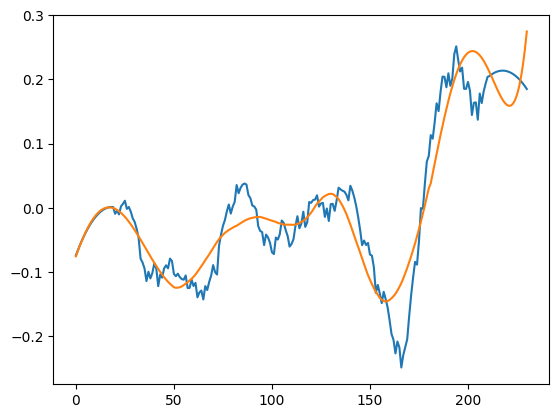

In [102]:
data = load_data(default_config)[0]
i = 0
plt.plot(data[:,i])
plt.plot(sg(data[:,i],window_length=100,polyorder=5))

INFO: # - Found file at /home/facosta/code/neuralgeom/neuralgeom/data/expt41_times_timestep1000000.txt! Loading...
INFO: # - Found file at /home/facosta/code/neuralgeom/neuralgeom/data/expt41_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at /home/facosta/code/neuralgeom/neuralgeom/data/expt41_labels_timestep1000000.txt! Loading...


      Unnamed: 0         times      angles  velocities  gains
0              0  2.398831e+09  218.096356   14.498892  1.000
1              1  2.399831e+09  228.319574    1.598267  1.000
2              2  2.400831e+09  229.646926    6.372364  1.000
3              3  2.401831e+09  241.624300   17.123473  1.000
4              4  2.402831e+09  269.453404   32.549442  1.000
...          ...           ...         ...         ...    ...
3877        3877  6.275831e+09  153.349456   23.023874  1.769
3878        3878  6.276831e+09  180.073147   32.645234  1.769
3879        3879  6.277831e+09  212.383674   20.877510  1.769
3880        3880  6.278831e+09  218.709534    1.998074  1.769
3881        3881  6.279831e+09  228.125413   16.185864  1.769

[3882 rows x 5 columns]
Dataset shape: (99, 12).


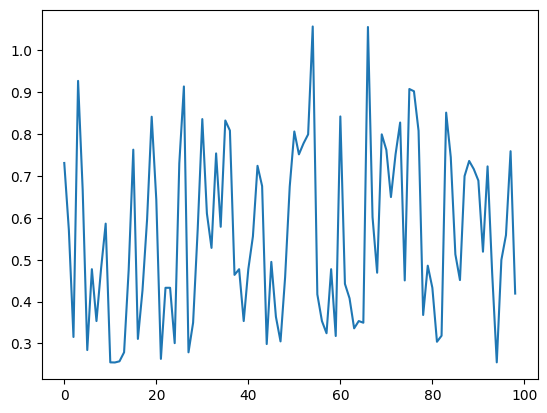

In [109]:
data = load_data(default_config)[0]
n = np.zeros(data.shape[0])

for i in range(data.shape[0]):
    norm = np.linalg.norm(data[i,:])
    n[i] = norm#/np.tanh(norm)

plt.plot(n)

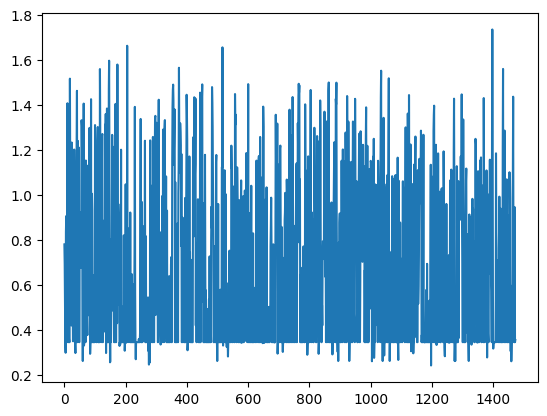

In [186]:
n = np.zeros(data.shape[0])

for i in range(data.shape[0]):
    norm = np.linalg.norm(data[i,:])
    n[i] = norm#/np.tanh(norm)

plt.plot(n)

In [148]:
data_smooth = torch.zeros_like(data)

for _ in range(data.shape[1]):
    data_smooth[:,_] = torch.from_numpy(sg(data[:,_],window_length=100,polyorder=4))

In [149]:
data_smooth.shape

torch.Size([428, 40])

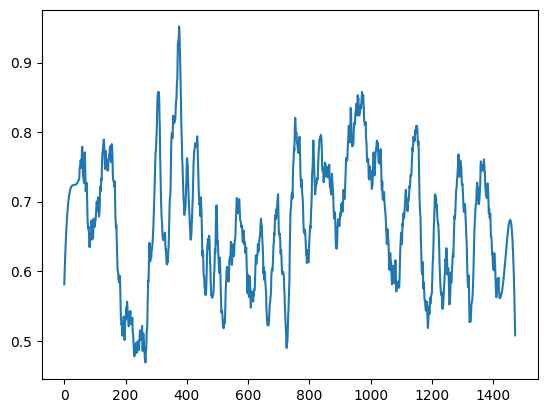

In [187]:
smooth = sg(n, window_length=100, polyorder=4)
plt.plot(smooth)

### PCA

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(data)
print(sum(pca.explained_variance_ratio_))
A = torch.tensor(pca.fit_transform(data))

In [ ]:
U, S, V = torch.pca_lowrank(data, q = 8, center=True)

### Pullback metric

In [98]:
import os
os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
from geomstats.geometry.pullback_metric import PullbackMetric


def get_immersion(radius):
    def immersion(angle):
        return radius*gs.array([gs.cos(angle),gs.sin(angle)])
    return immersion


immersion = get_immersion(radius=10)

metric = PullbackMetric(dim=1, embedding_dim=2, immersion=immersion)

In [101]:
base_point = gs.array([gs.pi])
metric.cometric_matrix(base_point)

tensor([[0.0100]])

/home/facosta/miniconda3/envs/ng2/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/facosta/miniconda3/envs/ng2/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


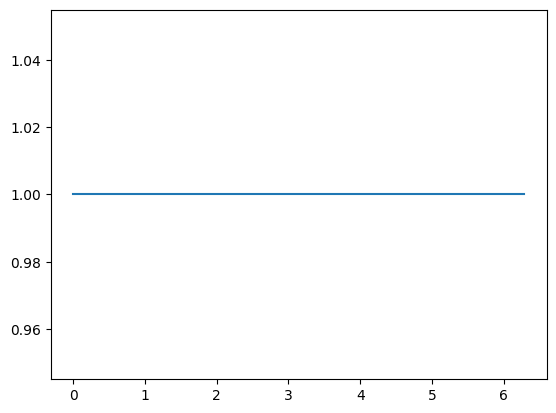

In [95]:
thetas = gs.linspace(0,2*gs.pi,100)

metrics = [metric.metric_matrix(gs.array([theta])) for theta in thetas]

plt.plot(thetas,metrics)

### Load place cell data, expt 41

In [47]:
from datasets.experimental import load_place_cells 

place_cells, labels = load_place_cells(expt_id=41, timestep_microsec=int(1e6))
print(place_cells.shape)

INFO: # - Found file at /home/facosta/code/neuralgeom/neuralgeom/data/expt41_times_timestep1000000.txt! Loading...
INFO: # - Found file at /home/facosta/code/neuralgeom/neuralgeom/data/expt41_place_cells_timestep1000000.npy! Loading...
INFO: # - Found file at /home/facosta/code/neuralgeom/neuralgeom/data/expt41_labels_timestep1000000.txt! Loading...


(3882, 12)


### Filter by gain

In [48]:
dataset = place_cells[labels["velocities"] > 5]

labels = labels[labels["velocities"] > 5]

In [49]:
dataset_1 = dataset[labels["gains"] == 1.0]
labels_1 = labels[labels["gains"] == 1.0]

In [51]:
dataset_2 = dataset[labels["gains"] == 1.768999993801117]
labels_2 = labels[labels["gains"] == 1.768999993801117]

### Filter by velocities

In [8]:
dataset = place_cells[labels["velocities"] > 10]

labels = labels[labels["velocities"] > 10]

### Visualize Sphere & Torus data

In [92]:
from datasets.synthetic import load_s2_synthetic as load_sphere

embedding_dim = 3
rot = torch.eye(3)
n_times = 200
radius = 1
distortion_amp = 0.3
noise_var = 1e-4

sphere_data, labels = load_sphere(rot, n_times,radius, distortion_amp,embedding_dim, noise_var)


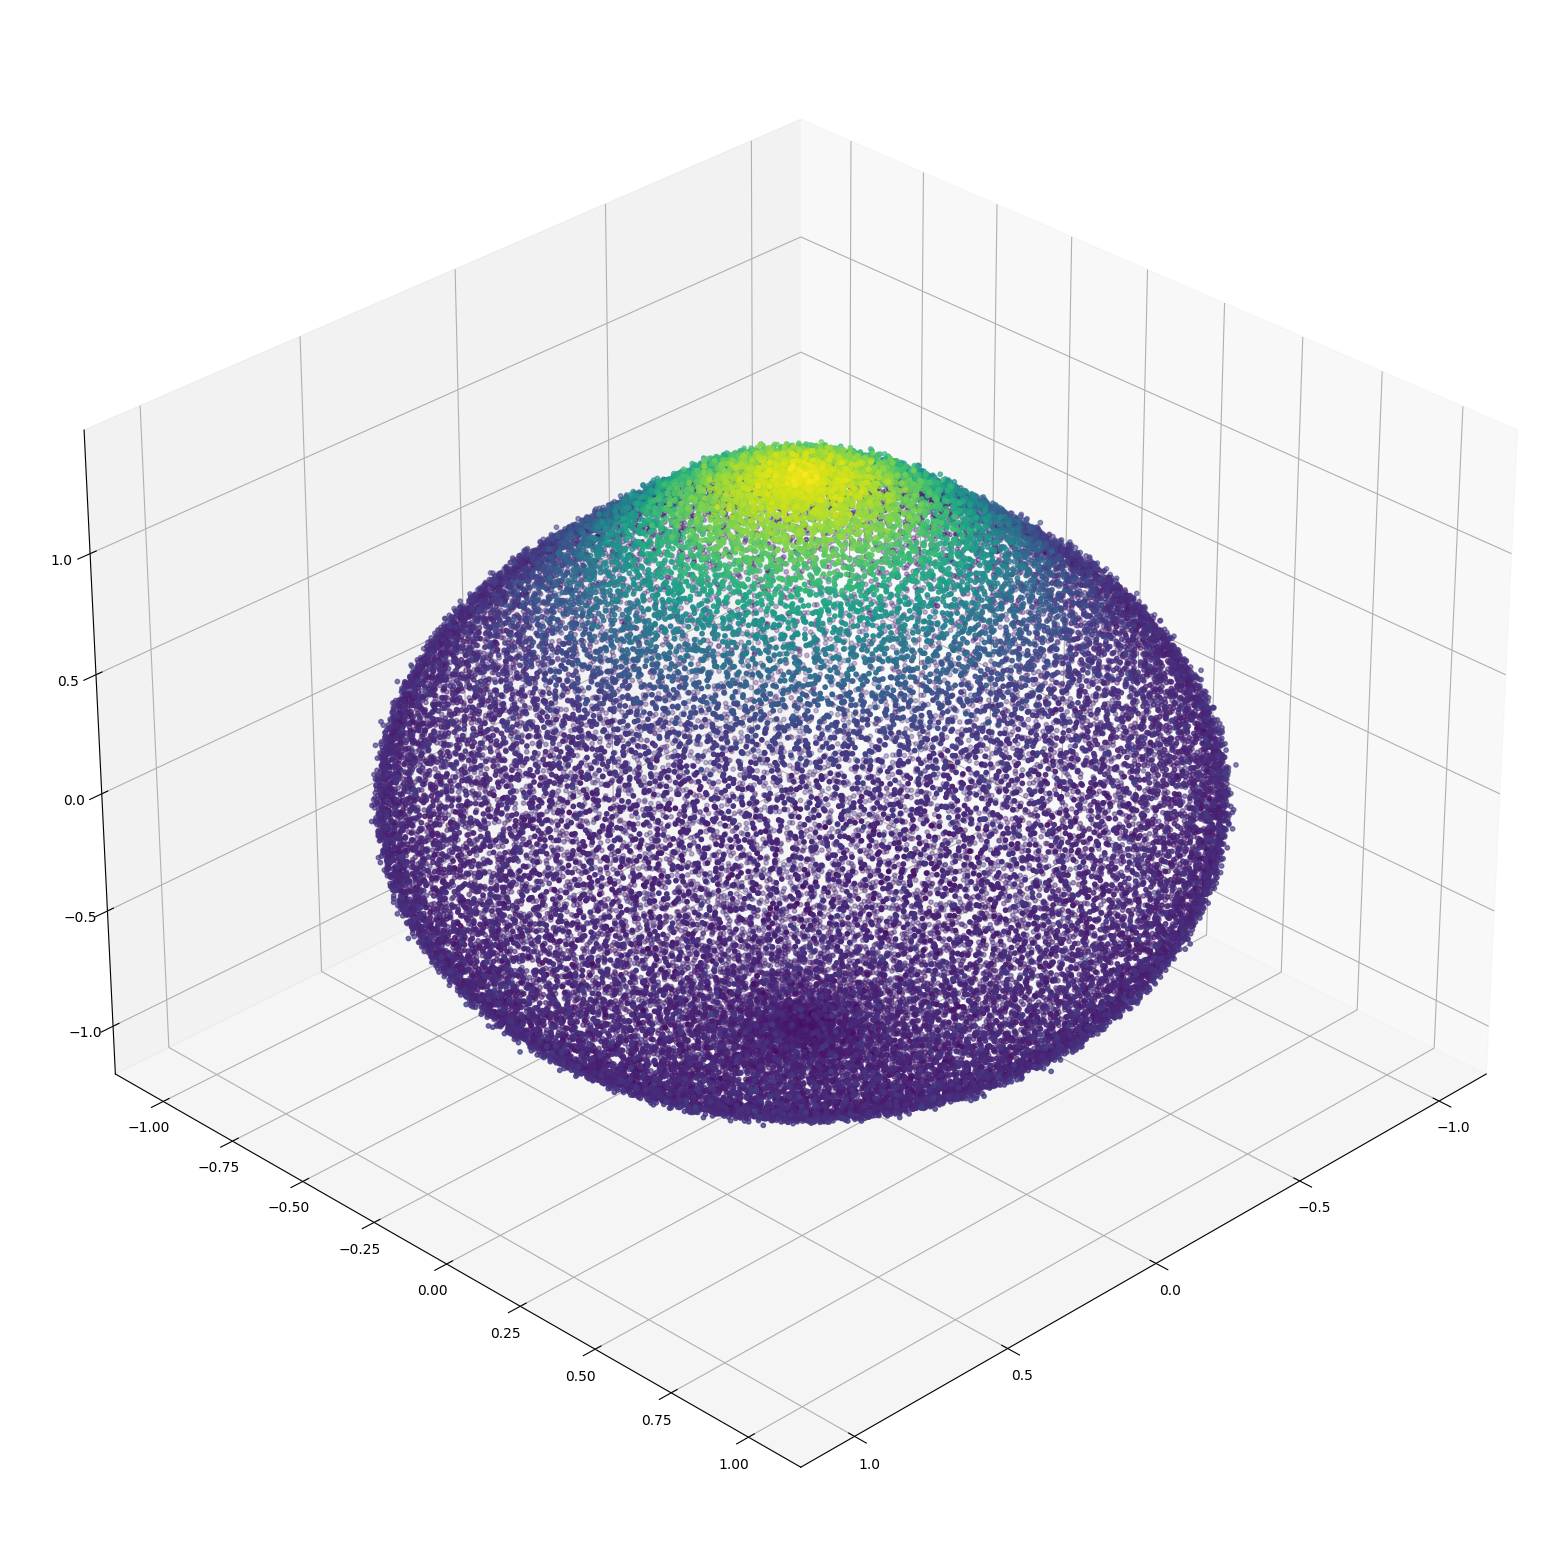

In [93]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')

x = sphere_data[:,0]
y = sphere_data[:,1]
z = sphere_data[:,2]

ax.scatter3D(x, y, z, s=10, c = np.linalg.norm(sphere_data,axis=1))

ax.view_init(elev=30, azim=45, roll=0)

In [105]:
from datasets.synthetic import load_t2_synthetic as load_torus

embedding_dim = 3
rot = torch.eye(3)
n_times = 200
major_radius = 2
minor_radius = 1
distortion_amp = 0.2
noise_var = 1e-4

torus_data, labels = load_torus(rot, n_times,major_radius, minor_radius, distortion_amp,embedding_dim, noise_var)

x = torus_data[:,0]
y = torus_data[:,1]
z = torus_data[:,2]

norms = np.linalg.norm(torus_data,axis=1)

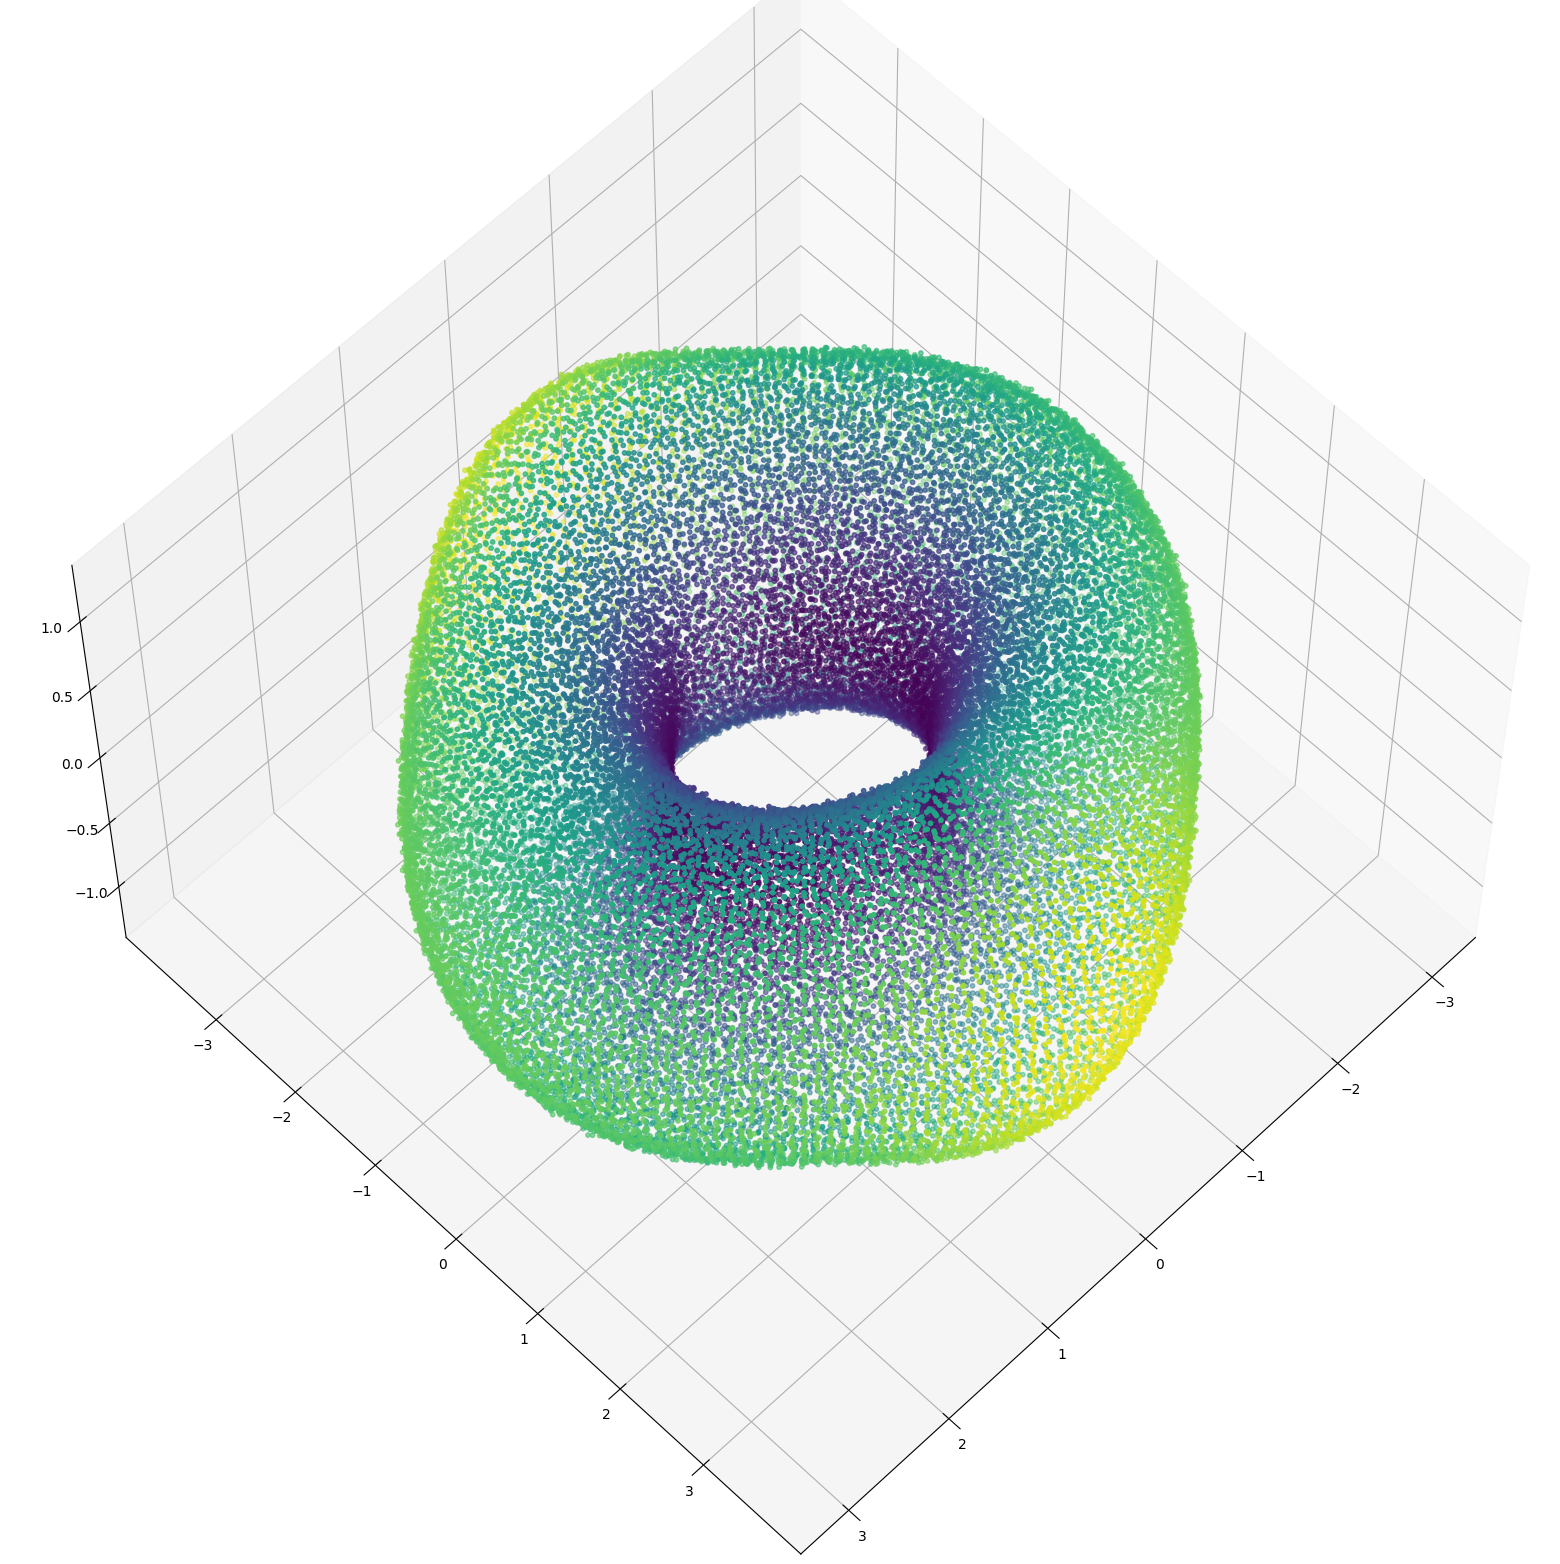

In [107]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')


ax.scatter3D(x, y, z, s=10, c = norms)
ax.view_init(elev=60, azim=45, roll=0)